## Recommendations with MovieTweetings: Collaborative Filtering

One of the most popular methods for making recommendations is **collaborative filtering**.  In collaborative filtering, you are using the collaboration of user-item recommendations to assist in making new recommendations.  

There are two main methods of performing collaborative filtering:

1. **Neighborhood-Based Collaborative Filtering**, which is based on the idea that we can either correlate items that are similar to provide recommendations or we can correlate users to one another to provide recommendations.

2. **Model Based Collaborative Filtering**, which is based on the idea that we can use machine learning and other mathematical models to understand the relationships that exist amongst items and users to predict ratings and provide ratings.


In this notebook, you will be working on performing **neighborhood-based collaborative filtering**.  There are two main methods for performing collaborative filtering:

1. **User-based collaborative filtering:** In this type of recommendation, users related to the user you would like to make recommendations for are used to create a recommendation.

2. **Item-based collaborative filtering:** In this type of recommendation, first you need to find the items that are most related to each other item (based on similar ratings).  Then you can use the ratings of an individual on those similar items to understand if a user will like the new item.

In this notebook you will be implementing **user-based collaborative filtering**.  However, it is easy to extend this approach to make recommendations using **item-based collaborative filtering**.  First, let's read in our data and necessary libraries.

**NOTE**: Because of the size of the datasets, some of your code cells here will take a while to execute, so be patient!

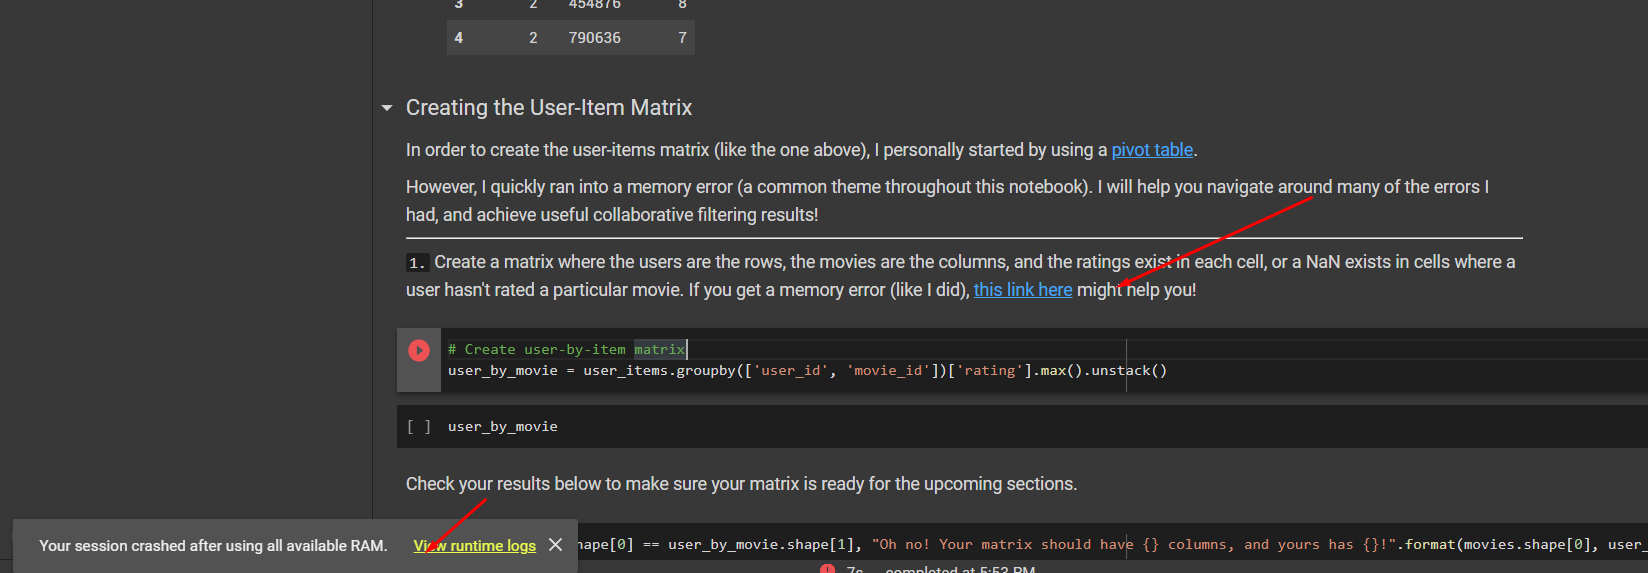
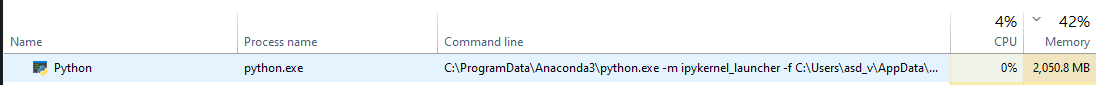
i cant run it i used smaller sample of the data to see results yet i cant assert !!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tests as t
from scipy.sparse import csr_matrix
from IPython.display import HTML


%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

print(reviews.head())

   user_id  movie_id  rating   timestamp                 date  month_1  \
0        1     68646      10  1381620027  2013-10-12 23:20:27        0   
1        1    113277      10  1379466669  2013-09-18 01:11:09        0   
2        2    422720       8  1412178746  2014-10-01 15:52:26        0   
3        2    454876       8  1394818630  2014-03-14 17:37:10        0   
4        2    790636       7  1389963947  2014-01-17 13:05:47        0   

   month_2  month_3  month_4  month_5  ...  month_9  month_10  month_11  \
0        0        0        0        0  ...        0         1         0   
1        0        0        0        0  ...        0         0         0   
2        0        0        0        0  ...        0         1         0   
3        0        0        0        0  ...        0         0         0   
4        0        0        0        0  ...        0         0         0   

   month_12  year_2013  year_2014  year_2015  year_2016  year_2017  year_2018  
0         0          1  

### Measures of Similarity

When using **neighborhood** based collaborative filtering, it is important to understand how to measure the similarity of users or items to one another.  

There are a number of ways in which we might measure the similarity between two vectors (which might be two users or two items).  In this notebook, we will look specifically at two measures used to compare vectors:

* **Pearson's correlation coefficient**

Pearson's correlation coefficient is a measure of the strength and direction of a linear relationship. The value for this coefficient is a value between -1 and 1 where -1 indicates a strong, negative linear relationship and 1 indicates a strong, positive linear relationship. 

If we have two vectors x and y, we can define the correlation between the vectors as:


$$CORR(x, y) = \frac{\text{COV}(x, y)}{\text{STDEV}(x)\text{ }\text{STDEV}(y)}$$

where 

$$\text{STDEV}(x) = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

and 

$$\text{COV}(x, y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})$$

where n is the length of the vector, which must be the same for both x and y and $\bar{x}$ is the mean of the observations in the vector.  

We can use the correlation coefficient to indicate how alike two vectors are to one another, where the closer to 1 the coefficient, the more alike the vectors are to one another.  There are some potential downsides to using this metric as a measure of similarity.  You will see some of these throughout this workbook.


* **Euclidean distance**

Euclidean distance is a measure of the straightline distance from one vector to another.  Because this is a measure of distance, larger values are an indication that two vectors are different from one another (which is different than Pearson's correlation coefficient).

Specifically, the euclidean distance between two vectors x and y is measured as:

$$ \text{EUCL}(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

Different from the correlation coefficient, no scaling is performed in the denominator.  Therefore, you need to make sure all of your data are on the same scale when using this metric.

**Note:** Because measuring similarity is often based on looking at the distance between vectors, it is important in these cases to scale your data or to have all data be in the same scale.  If some measures are on a 5 point scale, while others are on a 100 point scale, you are likely to have non-optimal results due to the difference in variability of your features.  In this case, we will not need to scale data because they are all on a 10 point scale, but it is always something to keep in mind!

------------

### User-Item Matrix

In order to calculate the similarities, it is common to put values in a matrix.  In this matrix, users are identified by each row, and items are represented by columns.  


![alt text](imgs/userxitem.png "User Item Matrix")


In the above matrix, you can see that **User 1** and **User 2** both used **Item 1**, and **User 2**, **User 3**, and **User 4** all used **Item 2**.  However, there are also a large number of missing values in the matrix for users who haven't used a particular item.  A matrix with many missing values (like the one above) is considered **sparse**.

Our first goal for this notebook is to create the above matrix with the **reviews** dataset.  However, instead of 1 values in each cell, you should have the actual rating.  

The users will indicate the rows, and the movies will exist across the columns. To create the user-item matrix, we only need the first three columns of the **reviews** dataframe, which you can see by running the cell below.

In [2]:
user_items = reviews[['user_id', 'movie_id', 'rating']]
user_items.head()

,user_id,movie_id,rating
0,1,68646,10
1,1,113277,10
2,2,422720,8
3,2,454876,8
4,2,790636,7


### Creating the User-Item Matrix

In order to create the user-items matrix (like the one above), I personally started by using a [pivot table](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html). 

However, I quickly ran into a memory error (a common theme throughout this notebook).  I will help you navigate around many of the errors I had, and achieve useful collaborative filtering results! 

_____

`1.` Create a matrix where the users are the rows, the movies are the columns, and the ratings exist in each cell, or a NaN exists in cells where a user hasn't rated a particular movie. If you get a memory error (like I did), [this link here](https://stackoverflow.com/questions/39648991/pandas-dataframe-pivot-memory-error) might help you!

In [3]:
# Create user-by-item matrix
user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

In [4]:
user_by_movie

movie_id,8,10,12,25,91,417,439,443,628,833,...,8144778,8144868,8206708,8289196,8324578,8335880,8342748,8342946,8402090,8439854
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check your results below to make sure your matrix is ready for the upcoming sections.

In [5]:
assert movies.shape[0] == user_by_movie.shape[1], "Oh no! Your matrix should have {} columns, and yours has {}!".format(movies.shape[0], user_by_movie.shape[1])
assert reviews.user_id.nunique() == user_by_movie.shape[0], "Oh no! Your matrix should have {} rows, and yours has {}!".format(reviews.user_id.nunique(), user_by_movie.shape[0])
print("Looks like you are all set! Proceed!")
HTML('<img src="images/greatjob.webp">')

Looks like you are all set! Proceed!


`2.` Now that you have a matrix of users by movies, use this matrix to create a dictionary where the key is each user and the value is an array of the movies each user has rated.

In [ ]:
# Create a dictionary with users and corresponding movies seen

def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    movies = np.array(user_items[user_items.user_id == user_id]['movie_id'])

    return movies


def create_user_movie_dict():
    '''
    INPUT: None
    OUTPUT: movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    Creates the movies_seen dictionary
    '''
    movies_seen = {}
    for moview in user_by_movie.index.values:
        movies_seen[moview]= user_by_movie.loc[moview,user_by_movie.loc[moview,:].notna()].index.values

    
    return movies_seen


# Use your function to return dictionary
movies_seen = create_user_movie_dict()

`3.` If a user hasn't rated more than 2 movies, we consider these users "too new".  Create a new dictionary that only contains users who have rated more than 2 movies.  This dictionary will be used for all the final steps of this workbook.

In [ ]:
# Remove individuals who have watched 2 or fewer movies - don't have enough data to make recs

def create_movies_to_analyze(movies_seen, lower_bound=2):
    '''
    INPUT:  
    movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    lower_bound - (an int) a user must have more movies seen than the lower bound to be added to the movies_to_analyze dictionary

    OUTPUT: 
    movies_to_analyze - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    The movies_seen and movies_to_analyze dictionaries should be the same except that the output dictionary has removed 
    
    '''
    
    # Do things to create updated dictionary
    movies_to_analyze = {}
    for _, (M_ID,array) in enumerate(movies_seen.items()):
        
        if len(array) > lower_bound:
            movies_to_analyze[M_ID]=array

    return movies_to_analyze


# Use your function to return your updated dictionary
movies_to_analyze = create_movies_to_analyze(movies_seen)

In [ ]:
# Run the tests below to check that your movies_to_analyze matches the solution
assert len(movies_to_analyze) == 23512, "Oops!  It doesn't look like your dictionary has the right number of individuals."
assert len(movies_to_analyze[2]) == 23, "Oops!  User 2 didn't match the number of movies we thought they would have."
assert len(movies_to_analyze[7])  == 3, "Oops!  User 7 didn't match the number of movies we thought they would have."
print("If this is all you see, you are good to go!")

### Calculating User Similarities

Now that you have set up the **movies_to_analyze** dictionary, it is time to take a closer look at the similarities between users.  Below is the pseudocode for how I thought about determining the similarity between users:

```
for user1 in movies_to_analyze
    for user2 in movies_to_analyze
        see how many movies match between the two users
        if more than two movies in common
            pull the overlapping movies
            compute the distance/similarity metric between ratings on the same movies for the two users
            store the users and the distance metric
```

However, this took a very long time to run, and other methods of performing these operations did not fit on the workspace memory!

Therefore, rather than creating a dataframe with all possible pairings of users in our data, your task for this question is to look at a few specific examples of the correlation between ratings given by two users.  For this question consider you want to compute the [correlation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) between users.

`4.` Using the **movies_to_analyze** dictionary and **user_by_movie** dataframe, create a function that computes the correlation between the ratings of similar movies for two users.  Then use your function to compare your results to ours using the tests below.  

In [ ]:
def compute_correlation(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    common_movies = np.intersect1d(movies_to_analyze(user1), movies_to_analyze(user2), assume_unique=True)
    corr = user_by_movie.loc[[user1,user2],common_movies].T.corr().iloc[0,1]
  
    return corr #return the correlation

In [ ]:
# Test your function against the solution
assert compute_correlation(2,2) == 1.0, "Oops!  The correlation between a user and itself should be 1.0."
assert round(compute_correlation(2,66), 2) == 0.76, "Oops!  The correlation between user 2 and 66 should be about 0.76."
assert np.isnan(compute_correlation(2,104)), "Oops!  The correlation between user 2 and 104 should be a NaN."

print("If this is all you see, then it looks like your function passed all of our tests!")

### Why the NaN's?

If the function you wrote passed all of the tests, then you have correctly set up your function to calculate the correlation between any two users.  

`5.` But one question is, why are we still obtaining **NaN** values?  As you can see in the code cell above, users 2 and 104 have a correlation of **NaN**. Why?

Think and write your ideas here about why these NaNs exist, and use the cells below to do some coding to validate your thoughts. You can check other pairs of users and see that there are actually many NaNs in our data - 2,526,710 of them in fact. These NaN's ultimately make the correlation coefficient a less than optimal measure of similarity between two users.




In [ ]:
# Which movies did both user 2 and user 104 see?
np.intersect1d(movies_to_analyze[2], movies_to_analyze[104])


In [ ]:
# What were the ratings for each user for those movies?
print(user_by_movie[movies_watched(104)])
print(user_by_movie[movies_watched(2)])

`6.` Because the correlation coefficient proved to be less than optimal for relating user ratings to one another, we could instead calculate the euclidean distance between the ratings.  I found [this post](https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy) particularly helpful when I was setting up my function.  This function should be very similar to your previous function.  When you feel confident with your function, test it against our results.

In [ ]:
def compute_euclidean_dist(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the euclidean distance between user1 and user2
    '''
    common_movies = np.intersect1d(movies_to_analyze[user1], movies_to_analyze[user2], assume_unique=True)
    user_by_moview = user_by_movie.loc[[user1, user2], common_movies]
    dist = np.linalg.norm(user_by_moview[0], user_by_moview[1], ord=2)
   
    return dist #return the euclidean distance

In [ ]:
# Test your function against the solution
assert compute_euclidean_dist(2,2) == 0, "Oops! Wrong"
assert round(compute_euclidean_dist(54,44), 2) == 5.1, "Oops! Wrong"
assert np.isnan(compute_euclidean_dist(2,104)) == False, "Oops! Wrong"

print("If this is all you see, then it looks like your function passed all of our tests!")

In [ ]:
# Read in solution euclidean distances"
import pickle
df_dists = pd.read_pickle("dists.p")

### Using the Nearest Neighbors to Make Recommendations

In the previous question, you read in **df_dists**. Therefore, you have a measure of distance between each user and every other user. This dataframe holds every possible pairing of users, as well as the corresponding euclidean distance.

Because of the **NaN** values that exist within the correlations of the matching ratings for many pairs of users, as we discussed above, we will proceed using **df_dists**. You will want to find the users that are 'nearest' each user.  Then you will want to find the movies the closest neighbors have liked to recommend to each user.

I made use of the following objects:

* df_dists (to obtain the neighbors)
* user_items (to obtain the movies the neighbors and users have rated)
* movies (to obtain the names of the movies)

`7.` Complete the functions below, which allow you to find the recommendations for any user.  There are five functions which you will need:

* **find_closest_neighbors** - this returns a list of user_ids from closest neighbor to farthest neighbor using euclidean distance


* **movies_liked** - returns an array of movie_ids


* **movie_names** - takes the output of movies_liked and returns a list of movie names associated with the movie_ids


* **make_recommendations** - takes a user id and goes through closest neighbors to return a list of movie names as recommendations


* **all_recommendations** = loops through every user and returns a dictionary of with the key as a user_id and the value as a list of movie recommendations

In [ ]:
def find_closest_neighbors(user):
    '''
    INPUT:
        user - (int) the user_id of the individual you want to find the closest users
    OUTPUT:
        closest_neighbors - an array of the id's of the users sorted from closest to farthest away
    '''
    # I treated ties as arbitrary and just kept whichever was easiest to keep using the head method
    # You might choose to do something less hand wavy - order the neighbors
    
    
    closest_neighbors = df_dists[df_dists["user1"]==user]\
    .sort_values(by="eucl_dist").reset_index(drop=True).iloc[1:,1].values
    return closest_neighbors
    
    
    
def movies_liked(user_id, min_rating=7):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    min_rating - the minimum rating considered while still a movie is still a "like" and not a "dislike"
    OUTPUT:
    movies_liked - an array of movies the user has watched and liked
    '''
    movies_liked= user_items[(user_items["user_id"]==user_id) \
    & (user_items["rating"]>=min_rating)]["movie_id"].values
    return movies_liked


def movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(map(lambda n: movies[movies["movie_id"]==n]["movie"].values[0] , movie_ids))
    return movie_lst
    
    
def make_recommendations(user, num_recs=10):
    '''
    INPUT:
        user - (int) a user_id of the individual you want to make recommendations for
        num_recs - (int) number of movies to return
    OUTPUT:
        recommendations - a list of movies - if there are "num_recs" recommendations return this many
                          otherwise return the total number of recommendations available for the "user"
                          which may just be an empty list
    '''
    recommendations = []
    closest_neighbors = find_closest_neighbors(user)
    
    for i_user in closest_neighbors:
        movies_liked_id = movies_liked(i_user)
        movies_lst = movie_names(movies_liked_id)
        recommendations.extend(movies_lst)
        
        if len(recommendations) >= num_recs:
            recommendations = recommendations[0:num_recs]
            break
    
    return recommendations

def all_recommendations(num_recs=10):
    '''
    INPUT 
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''
    all_recs = {}
    
    for i_user in user_items["user_id"].unique():
        recommendations = make_recommendations(i_user, num_recs)
        all_recs[i_user]= recommendations
        if i_user == 1503: #for test only
            break

    # Make the recommendations for each user
    
    
    return all_recs

all_recs = all_recommendations(10)

In [ ]:
# This loads our solution dictionary so you can compare results
all_recs_sol = pd.read_pickle("all_recs.p")

In [ ]:
assert all_recs[2] == make_recommendations(2), "Oops!  Your recommendations for user 2 didn't match ours."
assert all_recs[26] == make_recommendations(26), "Oops!  It actually wasn't possible to make any recommendations for user 26."
assert all_recs[1503] == make_recommendations(1503), "Oops! Looks like your solution for user 1503 didn't match ours."
print("If you made it here, you now have recommendations for many users using collaborative filtering!")
HTML('<img src="images/greatjob.webp">')

### Now What?

If you made it this far, you have successfully implemented a solution to making recommendations using collaborative filtering. 

`8.` Let's do a quick recap of the steps taken to obtain recommendations using collaborative filtering.  

In [ ]:
# Check your understanding of the results by correctly filling in the dictionary below
a = "pearson's correlation and spearman's correlation"
b = 'item based collaborative filtering'
c = "there were too many ratings to get a stable metric"
d = 'user based collaborative filtering'
e = "euclidean distance and pearson's correlation coefficient"
f = "manhattan distance and euclidean distance"
g = "spearman's correlation and euclidean distance"
h = "the spread in some ratings was zero"
i = 'content based recommendation'

sol_dict = {
    'The type of recommendation system implemented here was a ...': # letter here,
    'The two methods used to estimate user similarity were: ': # letter here,
    'There was an issue with using the correlation coefficient.  What was it?': # letter here
}

t.test_recs(sol_dict)

Additionally, let's take a closer look at some of the results.  There are two solution files that you read in to check your results, and you created these objects

* **df_dists** - a dataframe of user1, user2, euclidean distance between the two users
* **all_recs_sol** - a dictionary of all recommendations (key = user, value = list of recommendations)  

`9.` Use these two objects along with the cells below to correctly fill in the dictionary below and complete this notebook!

In [ ]:
a = 567
b = 1503
c = 1319
d = 1325
e = 2526710
f = 0
g = 'Use another method to make recommendations - content based, knowledge based, or model based collaborative filtering'

sol_dict2 = {
    'For how many pairs of users were we not able to obtain a measure of similarity using correlation?': # letter here,
    'For how many pairs of users were we not able to obtain a measure of similarity using euclidean distance?': # letter here,
    'For how many users were we unable to make any recommendations for using collaborative filtering?': # letter here,
    'For how many users were we unable to make 10 recommendations for using collaborative filtering?': # letter here,
    'What might be a way for us to get 10 recommendations for every user?': # letter here   
}

t.test_recs2(sol_dict2)

In [ ]:
# Use the cells below for any work you need to do!

In [ ]:
# Users without recs


In [ ]:
# NaN euclidean distance values


In [ ]:
# Users with less than 10 recs
